## Imports

In [26]:
%load_ext autoreload
%autoreload 2

import numpy as np
import tensorflow as tf

# Local imports from model.py, data.py
from model import CovidModel, Compartments, LogPoissonProb, get_logging_callbacks
from data import read_data, create_warmup
from plots import make_all_plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Controllable Parameters

### Data details

In [27]:
warmup_start = '20210401'
warmup_end = '20210430'
train_start = '20210501'
train_end = '20210731'
test_start = '20210801'
test_end = '20210831'

state = 'Massachusetts'
state_abbrev = 'MA'

data_dir = './data'
covid_estim_date = '20210901'
hhs_date = '20210903'
owid_date = '20210903'

log_dir = './logs/new_rho_in_warmup_0'

### Model Settings

In [28]:
# How long can a person take to progress?
transition_window = 20

# CovidEstim Hyper param
T_serial = 5.8

### Vaccine efficacy for incorrect warmup data split

In [29]:
# Vaccines are 90% effective at preventing infection
# according to a study of 4000 healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7013e3.htm
vax_asymp_risk = 0.90
# Vaccines are 94% effective at preventing symptomatic
# according to a study of healthcare workers in early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7020e2.htm
vax_mild_risk = 0.94
vax_extreme_risk = 0.94
# Vaccines are 94% effective at preventing hospitalization
# according to a study of adults over 65 early 2021
# https://www.cdc.gov/mmwr/volumes/70/wr/mm7018e1.htm?s_cid=mm7018e1_w
vax_general_ward_risk = 0.94 # not used

### Model prior parameters

In [30]:
# Parameters for the Beta distribution prior over rho, the probablility that
# someone progresses to the next state. Here we use a uniform distribution
# for all compartments, but we could specify a different prior for each M, X, G

# Copied from covid estim
# covidestim infected -> symptoms
alpha_bar_M = 5.5
beta_bar_M = 3.53
# covidestim symptoms -> severe
alpha_bar_X = 1.89
beta_bar_X = 20
# covid estim severe -> death
alpha_bar_G = 28.2
beta_bar_G = 162.3

# Parameters for the positive truncated Normal distribution prior over lambda, the rate
# parameter of the Poisson distribution controlling pi,
# which determines how quickly someone who progresses does so +
# Parameters for the positive truncated Normal distribution prior over nu, the parameter used
# to scale the poisson distribution governed by pi, allowing for a more expressive
# range of possible transition days

# We choose these values to match the gamma priors in covid estim
# Covidestim infected -> symptoms = Gamma(3.41, 0.61)
lambda_bar_M = 4.7
sigma_bar_M = 1.00
nu_bar_M = 1.70
tau_bar_M = 0.10

# Covidestim Symptoms -> severe = Gamma(1.72, 0.22)
lambda_bar_X = 4
sigma_bar_X = 0.5
nu_bar_X = 18
tau_bar_X = 8.1

# Covidestim severe -> death = Gamma(2.10, 0.23)
lambda_bar_G = 3.3
sigma_bar_G = 1
nu_bar_G = 9
tau_bar_G = 0.2


# Learning rate
learning_rate = 1e-1

## Read data

In [31]:
df = read_data(data_dir=data_dir,
               covid_estim_date=covid_estim_date,
               hhs_date=hhs_date,
               owid_date=owid_date,
               state=state, state_abbrev=state_abbrev)

In [32]:
# Optional, replace covidestim warmup data with fixed constants
df.loc[:,'extreme'] = 7*df.loc[:,'general_ward']
df.loc[:,'mild'] = 10*df.loc[:,'extreme']
df.loc[:,'asymp'] = 1.5*df.loc[:,'mild']

## Create warmup using incorrect efficacy assumption

In [33]:
warmup_asymp, warmup_mild, warmup_extreme = create_warmup(df, 
                                                          warmup_start, 
                                                          warmup_end,
                                                          vax_asymp_risk,
                                                          vax_mild_risk,
                                                          vax_extreme_risk)

## Create training Rt and outcome

In [34]:
training_rt = df.loc[train_start:train_end,'Rt'].values
training_general_ward = df.loc[train_start:train_end,'general_ward'].values

# Start the model from the training period so we are continuous
testing_rt = df.loc[train_start:test_end,'Rt'].values
testing_general_ward = df.loc[train_start:test_end,'general_ward'].values

## Build Model

In [35]:
model = CovidModel(transition_window, T_serial,
                     alpha_bar_M, beta_bar_M, alpha_bar_X, beta_bar_X, alpha_bar_G, beta_bar_G,
                 lambda_bar_M, sigma_bar_M, lambda_bar_X, sigma_bar_X, lambda_bar_G, sigma_bar_G,
                 nu_bar_M, tau_bar_M, nu_bar_X, tau_bar_X, nu_bar_X, tau_bar_X)

## Fit model

In [36]:
# Define optimizer
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate,
)

loss = LogPoissonProb()

model.compile(loss=loss, optimizer=optimizer, run_eagerly=True)
callbacks = get_logging_callbacks(log_dir)

2021-10-04 02:36:09.711396: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 02:36:09.711533: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 02:36:09.714030: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.
2021-10-04 02:36:09.714104: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-04 02:36:09.714458: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.


In [37]:
# Awkwardly stuff everything into an array

model.fit(x=(np.asarray([training_rt]),
       np.asarray([warmup_asymp[0]]), np.asarray([warmup_asymp[1]]),
       np.asarray([warmup_mild[0]+warmup_mild[1]]),
       np.asarray([warmup_extreme[0] +warmup_extreme[1]]),
       np.asarray([df.loc[warmup_start:warmup_end, 'vax_pct'].values])),
             y=np.asarray([training_general_ward]),
         epochs=500, batch_size=0, callbacks=callbacks)

Epoch 1/500
1/1 [==============================] - 1s 1s/step - loss: 2444.8308
Epoch 2/500


2021-10-04 02:36:16.096201: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-04 02:36:16.096236: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-04 02:36:16.096652: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1666] function cupti_interface_->Subscribe( &subscriber_, (CUpti_CallbackFunc)ApiCallback, this)failed with error CUPTI could not be loaded or symbol could not be found.


1/1 [==============================] - ETA: 0s - loss: 2413.0249

2021-10-04 02:36:17.115214: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-04 02:36:17.116219: E tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1757] function cupti_interface_->Finalize()failed with error CUPTI could not be loaded or symbol could not be found.
2021-10-04 02:36:17.162990: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-10-04 02:36:17.315129: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-04 02:36:17.710566: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_10_04_02_36_17



1/1 [==============================] - 2s 2s/step - loss: 2413.0249


2021-10-04 02:36:17.966458: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_10_04_02_36_17/MrChipsNVME.trace.json.gz
2021-10-04 02:36:18.053647: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_10_04_02_36_17

2021-10-04 02:36:18.056009: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_10_04_02_36_17/MrChipsNVME.memory_profile.json.gz
2021-10-04 02:36:18.072862: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_10_04_02_36_17
Dumped tool data for xplane.pb to ./logs/new_rho_in_warmup_0/train/plugins/profile/2021_10_04_02_36_17/MrChipsNVME.xplane.pb
Dumped tool data for overview_page.pb to ./lo

Epoch 3/500
1/1 [==============================] - 1s 930ms/step - loss: 2379.3435
Epoch 4/500
1/1 [==============================] - 1s 924ms/step - loss: 2342.9177
Epoch 5/500
1/1 [==============================] - 1s 911ms/step - loss: 2302.3867
Epoch 6/500
1/1 [==============================] - 1s 1s/step - loss: 2256.6143
Epoch 7/500
1/1 [==============================] - 1s 921ms/step - loss: 2204.9185
Epoch 8/500
1/1 [==============================] - 1s 905ms/step - loss: 2146.7632
Epoch 9/500
1/1 [==============================] - 1s 918ms/step - loss: 2081.5371
Epoch 10/500
1/1 [==============================] - 1s 907ms/step - loss: 2008.4941
Epoch 11/500
1/1 [==============================] - 1s 921ms/step - loss: 1926.7642
Epoch 12/500
1/1 [==============================] - 1s 920ms/step - loss: 1835.3906
Epoch 13/500
1/1 [==============================] - 1s 917ms/step - loss: 1733.4506
Epoch 14/500
1/1 [==============================] - 1s 1s/step - loss: 1620.2811
Epoch

1/1 [==============================] - 1s 960ms/step - loss: 309.5744
Epoch 103/500
1/1 [==============================] - 1s 1s/step - loss: 309.0605
Epoch 104/500
1/1 [==============================] - 1s 1s/step - loss: 308.6856
Epoch 105/500
1/1 [==============================] - 1s 994ms/step - loss: 308.4936
Epoch 106/500
1/1 [==============================] - 1s 1s/step - loss: 308.2999
Epoch 107/500
1/1 [==============================] - 1s 972ms/step - loss: 307.9807
Epoch 108/500
1/1 [==============================] - 1s 930ms/step - loss: 307.7037
Epoch 109/500
1/1 [==============================] - 1s 940ms/step - loss: 307.6349
Epoch 110/500
1/1 [==============================] - 1s 926ms/step - loss: 307.5610
Epoch 111/500
1/1 [==============================] - 1s 933ms/step - loss: 307.3504
Epoch 112/500
1/1 [==============================] - 1s 1s/step - loss: 307.2383
Epoch 113/500
1/1 [==============================] - 1s 965ms/step - loss: 307.1777
Epoch 114/500
1/1 

1/1 [==============================] - 1s 914ms/step - loss: 301.2238
Epoch 201/500
1/1 [==============================] - 1s 904ms/step - loss: 301.2155
Epoch 202/500
1/1 [==============================] - 1s 993ms/step - loss: 301.2072
Epoch 203/500
1/1 [==============================] - 1s 919ms/step - loss: 301.1993
Epoch 204/500
1/1 [==============================] - 1s 952ms/step - loss: 301.1915
Epoch 205/500
1/1 [==============================] - 1s 907ms/step - loss: 301.1841
Epoch 206/500
1/1 [==============================] - 1s 907ms/step - loss: 301.1767
Epoch 207/500
1/1 [==============================] - 1s 922ms/step - loss: 301.1696
Epoch 208/500
1/1 [==============================] - 1s 916ms/step - loss: 301.1627
Epoch 209/500
1/1 [==============================] - 1s 918ms/step - loss: 301.1559
Epoch 210/500
1/1 [==============================] - 1s 1s/step - loss: 301.1492
Epoch 211/500
1/1 [==============================] - 1s 918ms/step - loss: 301.1426
Epoch 212

Epoch 298/500
1/1 [==============================] - 1s 920ms/step - loss: 300.8206
Epoch 299/500
1/1 [==============================] - 1s 924ms/step - loss: 300.8177
Epoch 300/500
1/1 [==============================] - 1s 914ms/step - loss: 300.8151
Epoch 301/500
1/1 [==============================] - 1s 936ms/step - loss: 300.8124
Epoch 302/500
1/1 [==============================] - 1s 1s/step - loss: 300.8096
Epoch 303/500
1/1 [==============================] - 1s 914ms/step - loss: 300.8069
Epoch 304/500
1/1 [==============================] - 1s 912ms/step - loss: 300.8042
Epoch 305/500
1/1 [==============================] - 1s 912ms/step - loss: 300.8015
Epoch 306/500
1/1 [==============================] - 1s 902ms/step - loss: 300.7988
Epoch 307/500
1/1 [==============================] - 1s 907ms/step - loss: 300.7963
Epoch 308/500
1/1 [==============================] - 1s 997ms/step - loss: 300.7935
Epoch 309/500
1/1 [==============================] - 1s 897ms/step - loss: 300.

1/1 [==============================] - 1s 905ms/step - loss: 300.2076
Epoch 494/500
1/1 [==============================] - 1s 909ms/step - loss: 300.2033
Epoch 495/500
1/1 [==============================] - 1s 910ms/step - loss: 300.1990
Epoch 496/500
1/1 [==============================] - 1s 903ms/step - loss: 300.1949
Epoch 497/500
1/1 [==============================] - 1s 900ms/step - loss: 300.1906
Epoch 498/500
1/1 [==============================] - 1s 1s/step - loss: 300.1865
Epoch 499/500
1/1 [==============================] - 1s 903ms/step - loss: 300.1822
Epoch 500/500
1/1 [==============================] - 1s 916ms/step - loss: 300.1781


## Get predictions for train and test

## Call model with special flag to get values of all internal compartments

In [39]:
forecasted_fluxes = model((testing_rt,
       warmup_asymp[0], warmup_asymp[1],
       warmup_mild[0]+ warmup_mild[1],
       warmup_extreme[0]+ warmup_extreme[1],
                          df.loc[warmup_start:warmup_end, 'vax_pct'].values), return_all=True)

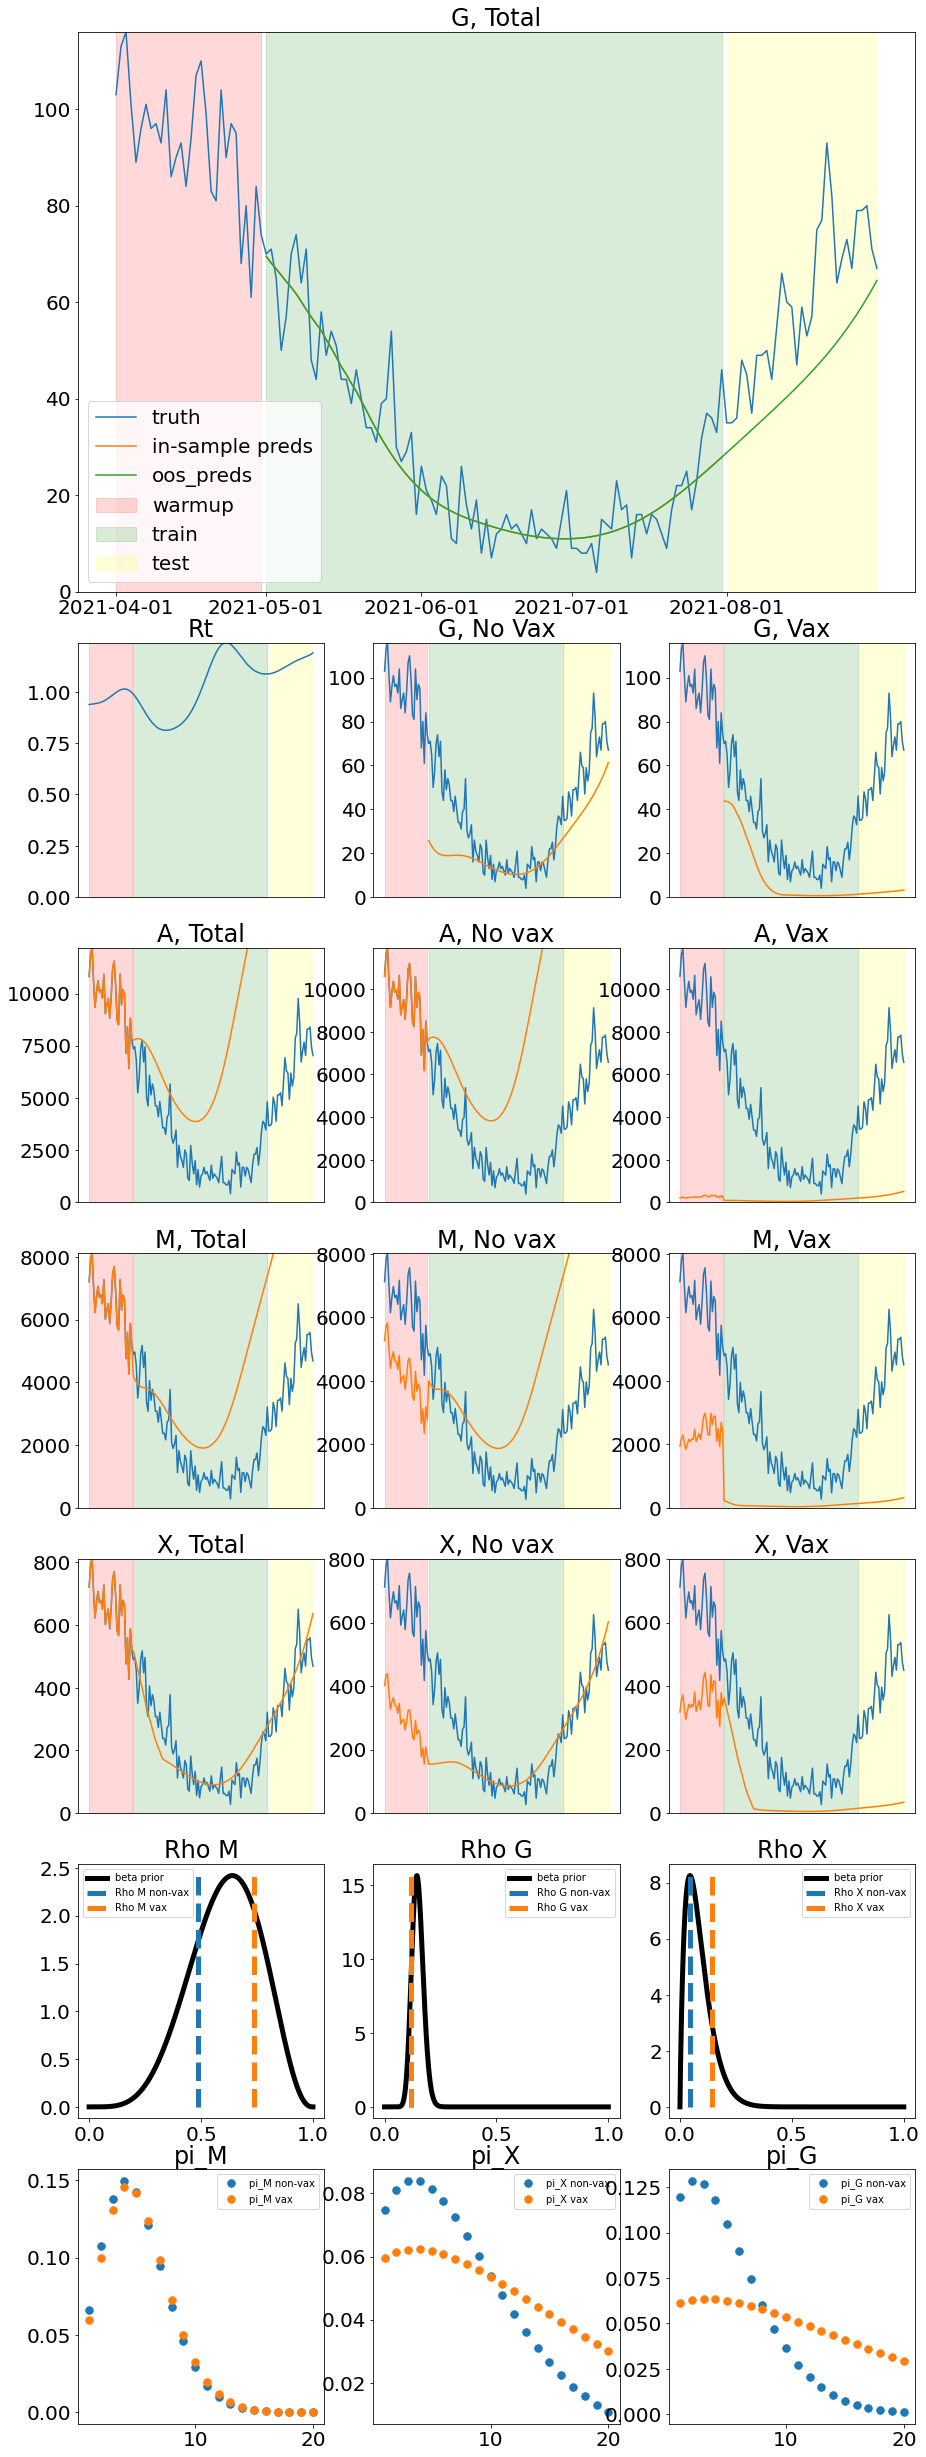

In [40]:
make_all_plots(df, model,
               alpha_bar_M, beta_bar_M,
               alpha_bar_X, beta_bar_X,
               alpha_bar_G, beta_bar_G,
                   warmup_start, warmup_end,
                   train_start, train_end,
                   test_start, test_end,
                   train_preds, test_preds,
                   vax_asymp_risk, vax_mild_risk, vax_extreme_risk,
                   forecasted_fluxes)

In [24]:
forecasted_fluxes[2][0].stack()[0] +forecasted_fluxes[2][1].stack()[0]

<tf.Tensor: shape=(), dtype=float32, numpy=721.0>

In [25]:
warmup_extreme

{1: array([ 8.418396,  9.482508, 10.01196 ,  8.97183 ,  8.066604,  8.777664,
         9.468144,  9.245376,  9.618714,  9.561888, 11.016096,  9.326184,
         9.89226 , 10.479798,  9.687888, 11.082036, 12.888792, 13.55046 ,
        12.415788, 10.520748, 10.44414 , 13.667472, 12.0771  , 13.330128,
        13.35054 ,  9.721824, 11.57856 ,  8.990058, 12.602016, 11.303796]),
 0: array([712.581604, 781.517492, 801.98804 , 698.02817 , 614.933396,
        663.222336, 697.531856, 662.754624, 669.381286, 641.438112,
        716.983904, 592.673816, 620.10774 , 640.520202, 578.312112,
        646.917964, 736.111208, 756.44954 , 680.584212, 570.479252,
        556.55586 , 714.332528, 617.9229  , 665.669872, 651.64946 ,
        466.278176, 548.42144 , 418.009942, 575.397984, 506.696204])}